# EXAMPLE: The planar pendulum again: from the Lagrangian to the EOMs via the Hamiltonian

We are going to address the simple pendulum again using the Lagrangian formalism we have been learning about in the lectures.

The first part of this example is exactly the same as the previous example, but we extend it using the Legendre transform at the end. The set up of the Lagrangian from the previous example is reproduced here for completeness.

To remind you what is going on, we'll refer to the diagram,
<center><img src='https://raw.githubusercontent.com/autofeedback-exercises/exercises/testpip/MTH2031/examples/pendulum.png' height=200 /></center>

Now, note that we are assuming the particle is just swinging back and forth in the $x-y$ plane. In other words we have two degrees of freedom, $x$ and $y$, and we assume that $z=0$ However, things can be simplified even further, as we have the additional constraint that $\sqrt{x^2+y^2} = l$, so we can actually cast our problem in terms of just one generalised coordinate, $q$. You will see most treatments of the pendulum use $\theta$ as the generalised coordinate, but to keep things general (and to match our notes) we will use $q$. 

Let's set up those constants, the generalised coordinate, $q$ and its derivative, $\dot{q}$.



In [17]:
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

t, l, m, g = sy.symbols('t, l, m, g')
q = sy.Function('q')(t)
qdot = sy.diff(q, t)

We can think of the particle's cartesian $(x,y)$ coordinates as being functions of the generalised coordinate $q$. More concretely, in this example we have that $x=l\sin q$ and $y=-l\cos q$ so that we have

In [2]:
x = l * sy.sin(q)
y = -l * sy.cos(q)

---

## Lagrangian

Let's introduce the kinetic, $T$, and potential,  $V$ energy, and the Lagrangian, $L$, as functions of our generalised coordinate. The only contribution to the kinetic energy comes from the motion of the particle, I.E
$$T = \dfrac{1}{2}m \left(v_x^2 + v_y^2\right),$$

where $v_x$ and $v_y$ are the $x$ and $y$ components of the velocity. We get these by differentiating $x$ and $y$:

In [3]:
T = sy.simplify( sy.Rational(1, 2) * m * (x.diff(t)**2 + y.diff(t)**2))
sy.pprint(T)

               2
 2   ⎛d       ⎞ 
l ⋅m⋅⎜──(q(t))⎟ 
     ⎝dt      ⎠ 
────────────────
       2        


The only contribution to the potential energy is due to the force of gravity, $V=mgy$

In [4]:
V = m*g*y
sy.pprint(V)

-g⋅l⋅m⋅cos(q(t))


And the Lagrangian, as always, is just $L=T-V$

In [5]:
L = sy.simplify(T-V)
sy.pprint(L)

    ⎛                            2⎞
    ⎜                  ⎛d       ⎞ ⎟
l⋅m⋅⎜2⋅g⋅cos(q(t)) + l⋅⎜──(q(t))⎟ ⎟
    ⎝                  ⎝dt      ⎠ ⎠
───────────────────────────────────
                 2                 


---

## Legendre Transform
So far this has been identical to the previous example. Now we are going to diverge from that example and use the Legendre transform to recast our problem using Hamilton's equations instead. 

The first step to obtain the Lagrangian's Legendre transform is to find the momentum conjugate to $q$. Note that here, the momentum is a function of both the generalised coordinate and its time derivative:  $p(q, \dot{q})$. Let's call the variable `pf` ('p function'). Recall that the momentum is defined as the derivative of the Lagrangian with respect to $\dot{q}$:

In [6]:
pf = sy.diff(L, qdot)
sy.pprint(pf)

 2   d       
l ⋅m⋅──(q(t))
     dt      


As a second step, we need the generalised velocity, $v= \frac{dq}{dt} =v(q,p)$. For this we introduce the independent variable `p`. While `p` and `pf` refer to the same physical quantity (momentum), they refer to a different mathematical object (`pf` is a function, and `p` is an independent variable) and therefore we need to use two different names within the code). Similarly, $v$ and $\dot{q}$ are the same quantity (velocity), but we need two different variables. If you find this confusing, well, so do I. It's one of the drawbacks of using sympy.

In [7]:
p = sy.Symbol('p')
v = sy.solve(sy.Eq(p,pf),qdot)[0]
sy.pprint(v)

 p  
────
 2  
l ⋅m


The 'solve' line needs some explanation. First we tell sympy that `p` and `pf` are the same quantity: `sy.Eq(p,pf)` builds a sympy equation with `p` as the LHS and `pf` as the RHS. Then we solve the resulting equation for $\dot{q}$. Finally, because the solve command gives us a list of all possible solutions, we select the first (there is only one in this case anyway) with the square bracketed 0: `[0]`. Remembering that $v= \frac{dq}{dt}$, we have thus found the velocity.

The final step is to write the Hamiltonian as a Legendre transform of the Lagrangian:
$$H(q,p) = pv - L(q,v)\vert_{v=v(p)}$$

In [8]:
H = v*p - L.subs(qdot,v)
sy.pprint(sy.simplify(H))

                      2  
                     p   
-g⋅l⋅m⋅cos(q(t)) + ──────
                      2  
                   2⋅l ⋅m


---

## Hamilton's Equations (numerical solution)

Once we have obtained the Hamiltonian, Hamilton's equations are given as
$$\dfrac{dq}{dt} = \dfrac{\partial H}{\partial p}$$
$$\dfrac{dp}{dt} = -\dfrac{\partial H}{\partial q}$$

To set these up and solve them in sympy we apply some of the skills we have used before: transforming the symbolic expressions into numerical functions using `lambdify` and then using `odeint` to integrate the coupled, first-order ordinary differential equations. First we build the right-hand-sides of the equations (without the minus sign at this stage),

In [9]:
dHdq = sy.diff(H, q)
dHdp = sy.diff(H, p)
sy.pprint(dHdq)
sy.pprint(dHdp)

g⋅l⋅m⋅sin(q(t))
 p  
────
 2  
l ⋅m


Next, we define the `ode` function, to be passed to `odeint`. The function takes a vector with the values of $q$, $p$ the time $t$ and returns $\dot{q}$, $\dot{p}$ according to the Hamilton equations. We also have to give numerical values to the physical parameters: the acceleration due to gravity, the length of the rod and the mass. We call these numerical values `gg`, `ll` and `mm` to distinguish them from their symbolic counterparts, `g`, `l` and `m`.

In [11]:
np_dHdq = sy.lambdify([q, p, g, l, m], dHdq)
np_dHdp = sy.lambdify([q, p, l, m], dHdp)
gg = 9.81 # m/s^2
ll = 1 # m
mm = 1 # kg
par = [gg, ll, mm]

def ode(y, t, pars=par):
    g, l, m = par
    q, p = y
    return [np_dHdp(q, p, l, m), -np_dHdq(q, p, g, l, m)]

To solve our equations, we define some initial conditions. For example, let's have an initial position of $q=\frac{\pi}{6}, and an initial momentum of $p=0$. This corresponds to releasing the pendulum from rest at an angle of $\theta = \frac{\pi}{6} to the vertical.

<Figure size 640x480 with 0 Axes>

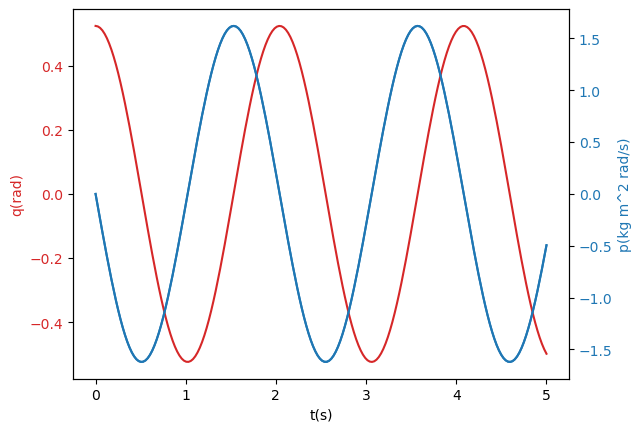

In [19]:
t = np.linspace(0, 5, 200)
initial = [np.pi/6, 0]
vec = odeint(ode, initial, t, args=(par,))
# unpack the result:
qq = vec[:, 0]
pp = vec[:, 1] 

# plot the position (angle) and momentum on the same axes
# use different colours for the different y-axes.
plt.figure()
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.plot(t, qq, color=color)
ax1.set_xlabel('t(s)')
ax1.set_ylabel('q(rad)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
plt.plot(t,pp)
ax2.set_ylabel('p(kg m^2 rad/s)', color=color)
ax2.plot(t, pp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

Text(0.5, 0, 'q(rad)')

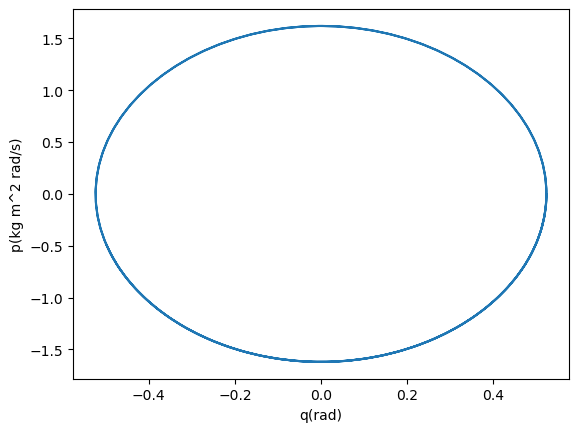

In [20]:
# phase plot
plt.figure()
plt.plot(qq, pp)
plt.ylabel('p(kg m^2 rad/s)')
plt.xlabel('q(rad)')